In [1]:
from comet_ml import Experiment

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.distributions import MultivariateNormal

import flows
import nn as flows_nn

from tqdm.notebook import tqdm

In [2]:
%env CUDA_VISIBLE_DEVICES=0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

env: CUDA_VISIBLE_DEVICES=0


device(type='cpu')

### Datasets:

In [3]:
# Lightweight datasets
import pickle
from sklearn import datasets

class DatasetMoons:
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moons)

class DatasetMixture:
    def sample(self, n):
        assert n%4 == 0
        r = np.r_[np.random.randn(n // 4, 2)*0.5 + np.array([0, -2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([0, 0]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([2, 2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([-2, 2])]
        return torch.from_numpy(r.astype(np.float32))

moons = DatasetMoons()
blobs = DatasetMixture()


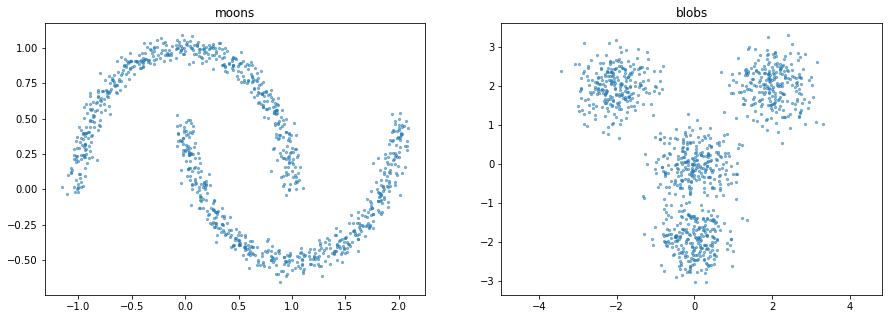

In [4]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.title('moons')
moons_sample = moons.sample(1000)
plt.scatter(moons_sample[:, 0], moons_sample[:, 1], s=5, alpha=0.5)
plt.subplot(1, 2, 2)
plt.title('blobs')
blobs_sample = blobs.sample(1000)
plt.scatter(blobs_sample[:, 0], blobs_sample[:, 1], s=5, alpha=0.5)
plt.axis('equal')
plt.show()

### Models:


In [5]:
dim = 2
prior = MultivariateNormal(torch.zeros(dim), torch.eye(dim))


In [6]:
MAF = [flows.MAF(dim=dim, base_network=flows_nn.ARMLP),
       flows.InvertiblePermutation(dim=dim),
       flows.MAF(dim=dim, base_network=flows_nn.ARMLP)]
MAF = flows.NormalizingFlowModel(prior, MAF).to(device)

SPLINE = [flows.ActNorm(dim=dim),
          flows.Invertible1x1Conv(dim=dim),
          flows.NSF_AR(dim=dim, K=8, B=3, hidden_features=32, base_network=flows_nn.MLP),
          flows.ActNorm(dim=dim),
          flows.Invertible1x1Conv(dim=dim),
          flows.NSF_AR(dim=dim, K=8, B=3, hidden_features=32, base_network=flows_nn.MLP)]
SPLINE = flows.NormalizingFlowModel(prior, SPLINE).to(device)

GLOW = [flows.ActNorm(dim=dim),
        flows.Invertible1x1Conv(dim=dim),
        flows.AffineHalfFlow(dim=dim, hidden_features=32, base_network=flows_nn.MLP),
        flows.InvertiblePermutation(dim=dim),
        flows.ActNorm(dim=dim),
        flows.Invertible1x1Conv(dim=dim),
        flows.AffineHalfFlow(dim=dim, hidden_features=32, base_network=flows_nn.MLP),
        flows.InvertiblePermutation(dim=dim)]
GLOW = flows.NormalizingFlowModel(prior, GLOW).to(device)

RealNVP = [flows.AffineHalfFlow(dim=dim, hidden_features=32, base_network=flows_nn.MLP),
           flows.InvertiblePermutation(dim=dim),
           flows.AffineHalfFlow(dim=dim, hidden_features=32, base_network=flows_nn.MLP),
           flows.InvertiblePermutation(dim=dim)
          ]
RealNVP = flows.NormalizingFlowModel(prior, RealNVP).to(device)

### Train:

In [7]:
def plot_sample(model, sampler):
    real = sampler.sample(1000).detach().cpu()
    fake = model.sample(1000).detach().cpu()
    plt.scatter(real[:, 0], real[:, 1], label='real', c='blue', alpha=0.7, s=1)
    plt.scatter(fake[:, 0], fake[:, 1], label='fake', c='pink', alpha=0.5, s=1)
    plt.legend()
    plt.grid()

In [8]:
for model, model_name in zip(tqdm([MAF, SPLINE, GLOW, RealNVP], position=0),
                             ['MAF', 'SPLINE', 'GLOW', 'RealNVP']):
    for sampler, sampler_name in zip([moons, blobs], ['moons', 'blobs']):
        optimizer = torch.optim.Adam(model.parameters())
        experiment = Experiment(api_key="gRPSBi6ZfMyOREfIgTbJQpg0F",
                                project_name="mrartemev-nflib",
                                workspace="mrartemev", log_code=False, parse_args=False,
                                log_env_details=False, log_env_gpu=False, log_env_cpu=False, log_env_host=False,
                                log_graph=False, auto_metric_logging=True,
                                disabled=False, display_summary_level=0)
        experiment.log_metric('num_parameners', sum(p.numel() for p in model.parameters()))
        experiment.add_tags([sampler_name, model_name])
        with experiment.train():
            model.train()
            for iteration in range(5000):
                sample = sampler.sample(100)
                zs, prior_logprob, log_det = model(sample.to(device))
                logprob = prior_logprob + log_det
                loss = -torch.sum(logprob)
                model.zero_grad()
                loss.backward()
                optimizer.step()
                experiment.log_metric("loss", loss.item(), step=iteration)
        with experiment.validate():
            model.eval()
            plot_sample(model, sampler)
            experiment.log_figure(figure_name=f"{sampler_name}_{model_name}_last", step=iteration)
            plt.clf();

        experiment.end()



COMET INFO: Experiment is live on comet.ml https://www.comet.ml/mrartemev/mrartemev-nflib/949bcccfc8194418bd4a43166baa3a95

COMET INFO: Uploading stats to Comet before program termination (may take several seconds)
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: Still uploading
COMET INFO: Still uploading
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/mrartemev/mrartemev-nflib/5bf349644d86412eb350f4e43cfdc229

COMET INFO: Uploading stats to Comet before program termination (may take several seconds)
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: Still uploading
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/mrartemev/mrartemev-nflib/2b0871bf52bc4a0f9e9b5b9fd94edfe7

COMET INFO: Uploading stats to Comet before program termination (may take several seconds)
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: Still uploadi

<Figure size 432x288 with 0 Axes>